# Cell Assemly

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

[2024-08-19 11:36:16,609][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-08-19 11:36:17,833][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
import matplotlib
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,find_spikes
                            )
from spyglass.shijiegu.fragmented import permute_frag_cont,find_spike_count_ratio,get_nwb_units,classify_cells,find_firing_cross_correlation
from spyglass.shijiegu.placefield import cell_by_arm

In [4]:
nwb_copy_file_name = "eliot20221022_.nwb"

In [5]:
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221022_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221022_ 2         02_Seq2Session pos 1 valid ti
eliot20221022_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221022_ 4         04_Seq2Session pos 3 valid ti
eliot20221022_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221022_ 6         06_Seq2Session pos 5 valid ti
eliot20221022_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221022_ 8         08_Seq2Session pos 7 valid ti
eliot20221022_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221022_ 10        10_Seq2Session pos 9 valid ti
eliot20221022_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



In [6]:
epoch_num = 3
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]

In [1]:
try:
    ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))
except:
    ripple_times = pd.read_pickle((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

NameError: name 'pd' is not defined

In [8]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}

In [9]:
sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))
sort_group_ids_with_good_cell = []
for sort_group_id in sort_group_ids:
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id)
    if len(nwb_units)==0:
        continue
    sort_group_ids_with_good_cell.append(sort_group_id)
print(sort_group_ids_with_good_cell)

[0, 2, 5, 13, 14, 16, 17, 20, 23, 26, 27, 30, 31]


In [10]:
nwb_units_all = get_nwb_units(nwb_copy_file_name,session_name,sort_group_ids_with_good_cell)

In [11]:
count_ratio, firing_rate_F, firing_rate_C = find_spike_count_ratio(nwb_units_all,ripple_times)

In [12]:
cells_frag, cells_cont = classify_cells(firing_rate_F, firing_rate_C)

electrode 0 unit 3
during fragmented replay:  7.304430676138095 31.0
during cont replay:  3.709264109928835 84.0
electrode 0 unit 4
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.04415790607058137 1.0
electrode 0 unit 6
during fragmented replay:  2.8275215520534562 12.0
during cont replay:  1.9871057731761617 45.0
electrode 0 unit 7
during fragmented replay:  3.5344019400668203 15.0
during cont replay:  0.7506844031998833 17.0
electrode 0 unit 8
during fragmented replay:  1.1781339800222734 5.0
during cont replay:  0.1324737182117441 3.0
electrode 2 unit 3
during fragmented replay:  2.356267960044547 10.0
during cont replay:  1.1481055578351156 26.0
electrode 5 unit 2
during fragmented replay:  0.0 0.0
during cont replay:  0.9273160274822088 21.0
electrode 5 unit 5
during fragmented replay:  2.120641164040092 9.0
during cont replay:  0.30910534249406957 7.0
electrode 5 unit 6
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.0 0.0
elec

### Get place fields

In [13]:
cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in nwb_units_all[e].index:
        cell_list.append((e, u))
        
placefields = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = place_field(
        nwb_copy_file_name, session_name, pos_name, e, u)
    placefields[(e,u)] = placefield
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [14]:
peak1ds={}
peak1ds_list = []

for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    peak1d = placefield_to_peak1dloc('4 arm lumped 2023', placefields[(e,u)], ybins, xbins)
    peak1ds[(e,u)] = peak1d
    peak1ds_list.append(peak1d)

[11:53:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


0


[11:53:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


1


[11:53:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


2


[11:53:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


3


[11:53:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


4


[11:53:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


5


[11:53:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


6


[11:53:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


7


[11:53:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


8


[11:53:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


9


[11:53:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


10


[11:53:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


11


[11:53:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


12


[11:53:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


13


[11:53:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


14


[11:53:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


15


[11:53:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


16


[11:53:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


17


[11:53:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


18


[11:54:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


19


[11:54:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


20


[11:54:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


21


[11:54:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


22


[11:54:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


23


[11:54:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


24


[11:54:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


25


[11:54:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


26


[11:54:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


27


[11:54:08][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


28


[11:54:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


29


[11:54:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


30


[11:54:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


31


[11:54:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


32


[11:54:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


33


[11:54:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


34


[11:54:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


35


[11:54:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


36


[11:54:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


37


[11:54:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


38


[11:54:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


39


[11:54:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


40


[11:54:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


41


[11:54:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


42


[11:54:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


43


[11:54:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


44


[11:54:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


45


[11:54:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


46


[11:54:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


47


[11:54:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


48


[11:54:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


49


[11:54:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


50


[11:54:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


51


[11:54:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


52


[11:54:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


53


[11:54:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


54


[11:54:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


55


[11:54:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


56


[11:54:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


57


[11:54:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


58


[11:54:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


59


[11:54:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


60


[11:54:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


61


[11:54:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


62


[11:54:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


63


[11:54:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


64


[11:54:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


65


[11:54:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


66


[11:54:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


67


[11:54:44][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


68


[11:54:45][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


69


[11:54:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


70


[11:54:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


71


[11:54:48][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


72


[11:54:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


73


[11:54:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


74


[11:54:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


75


[11:54:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


76


[11:54:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


77


[11:54:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


78


[11:54:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


79


[11:54:57][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


80


[11:54:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


81


[11:54:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


82


[11:55:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


83


[11:55:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


84


[11:55:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


85


[11:55:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


86


[11:55:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


87


[11:55:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


88


[11:55:05][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


89


In [15]:
cell_list_by_arm, cell_list_ind_by_arm = cell_by_arm(peak1ds_list, cell_list)

[11:55:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


### 1. For each fragmented event, for all cells that fired, create union

In [16]:
from spyglass.shijiegu.fragmented_graph import find_active_cells, make_graph
import networkx as nx

In [307]:
# make graph
indices_frag = find_active_cells(ripple_times, nwb_units_all, cell_list, cont = False)
indices_cont = find_active_cells(ripple_times, nwb_units_all, cell_list, cont = True)

G_frag, weights_frag = make_graph(cell_list, indices_frag)
G_cont, weights_cont = make_graph(cell_list, indices_cont)

In [87]:
# color code by spike count ratio
log_ratio = np.log(count_ratio)
norm = matplotlib.colors.Normalize(vmin=-1, vmax=2)
cmap = matplotlib.cm.get_cmap('YlGn_r')

color_ratio = {}
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    color_ratio[cell]  = cmap(norm(log_ratio[cell_ind]))

# color code by place field peak location
norm = matplotlib.colors.Normalize(vmin=0, vmax=800)
cmap = matplotlib.cm.get_cmap('jet')

color_fieldPeak = {}
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    color_fieldPeak[cell]  = cmap(norm(peak1ds_list[cell_ind]))

# for home, color them as grey
cmap_bone = matplotlib.cm.get_cmap('bone')
rgba_grey = cmap_bone(0.5)
for cell in cell_list_by_arm['home']:
    color_fieldPeak[tuple(cell)]  = rgba_grey

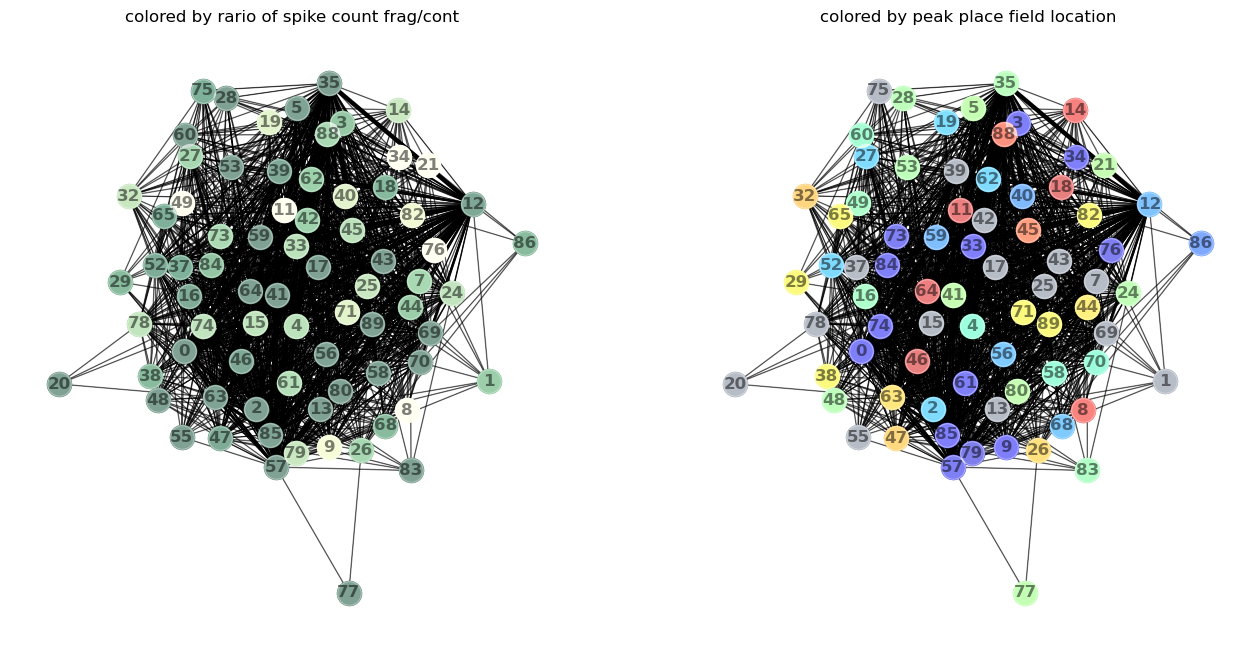

In [301]:
fig, axes = plt.subplots(1,2, figsize = (16,8))

pos = nx.kamada_kawai_layout(G_frag, weight = 'weight')
#pos = nx.bfs_layout(G)

# ratio color
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    try:
        nx.draw_networkx_nodes(G_frag, pos, ax=axes[0], 
                               nodelist=[cell_ind], node_color=color_ratio[cell]) #the order of plotting matters here
    except:
        pass

nx.draw(G_frag, pos, ax=axes[0], with_labels=True, font_weight='bold',node_color = [1,1,1],alpha = 0.5)
axes[0].set_title('colored by rario of spike count frag/cont')
for edge in G_frag.edges(data='weight'):
    nx.draw_networkx_edges(G_frag, pos, ax=axes[0], edgelist=[edge], width=edge[2]/5)
    
# color_fieldPeak
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    try:
        nx.draw_networkx_nodes(G_frag, pos, ax=axes[1], 
                               nodelist=[cell_ind], node_color=color_fieldPeak[cell]) #the order of plotting matters here
    except:
        pass

nx.draw(G_frag, pos, ax=axes[1], with_labels=True, font_weight='bold',node_color = [1,1,1],alpha = 0.5)
axes[1].set_title('colored by peak place field location')

#nx.draw(G, pos, with_labels=True,  node_color = [1,1,1])
#nx.draw_networkx_labels(G,pos,cell0_list);
#nx.draw_networkx_labels(G,pos,cell1_list);
#plt.colorbar()
for edge in G_frag.edges(data='weight'):
    nx.draw_networkx_edges(G_frag, pos, ax=axes[1], edgelist=[edge], width=edge[2]/5)

Light yellow ones are cells with high fragmented/cont ratio.
The ones in the center, with darker green, have low fragmented/cont ratio.

### Do the same for cont replay

In [316]:
"""
pos3d = nx.spectral_layout(G_cont, weight = 'weight',dim = 3)
pos = {}
for keys in pos3d.keys():
    pos[keys] = pos3d[keys][:-1]
"""

"\npos3d = nx.spectral_layout(G_cont, weight = 'weight',dim = 3)\npos = {}\nfor keys in pos3d.keys():\n    pos[keys] = pos3d[keys][:-1]\n"

In [323]:
from spyglass.shijiegu.fragmented_graph import bfs_layout

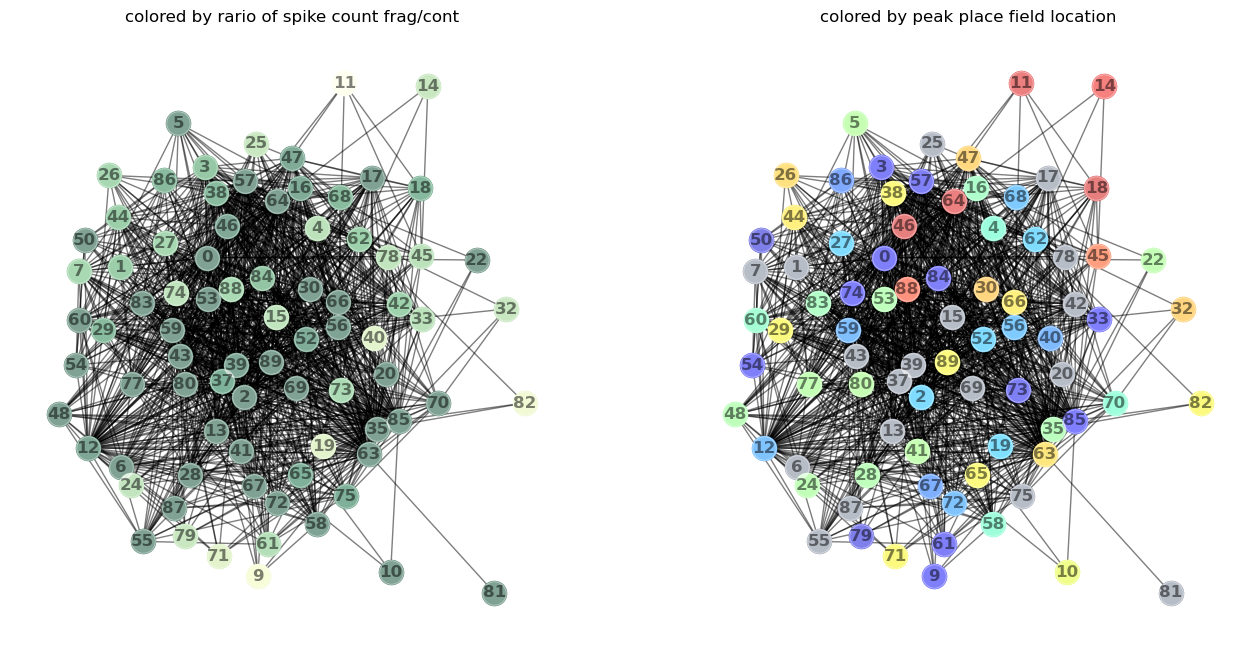

In [331]:
fig, axes = plt.subplots(1,2, figsize = (16,8))

pos = nx.kamada_kawai_layout(G_cont) 
#pos = nx.bfs_layout(G)
#pos = bfs_layout(G_cont, 18)

# ratio color
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    try:
        nx.draw_networkx_nodes(G_cont, pos, ax=axes[0], 
                               nodelist=[cell_ind], node_color=color_ratio[cell]) #the order of plotting matters here
    except:
        pass

nx.draw(G_cont, pos, ax=axes[0], with_labels=True, font_weight='bold',node_color = [1,1,1],alpha = 0.5)
for edge in G_cont.edges(data='weight'):
    nx.draw_networkx_edges(G_cont, pos, ax=axes[0], edgelist=[edge], width=edge[2]/5)
    
axes[0].set_title('colored by rario of spike count frag/cont')

# color_fieldPeak
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    try:
        nx.draw_networkx_nodes(G_cont, pos, ax=axes[1], 
                               nodelist=[cell_ind], node_color=color_fieldPeak[cell]) #the order of plotting matters here
    except:
        pass

nx.draw(G_cont, pos, ax=axes[1], with_labels=True, font_weight='bold',node_color = [1,1,1],alpha = 0.5)
axes[1].set_title('colored by peak place field location')

for edge in G_cont.edges(data='weight'):
    nx.draw_networkx_edges(G_cont, pos, ax=axes[1], edgelist=[edge], width=edge[2]/5)

(array([  0., 619., 202., 108.,  61.,  36.,  36.,  28.,  17.,  19.,  10.,
          5.,   6.,   2.,   1.,   2.,   2.,   2.,   5.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 19 artists>)

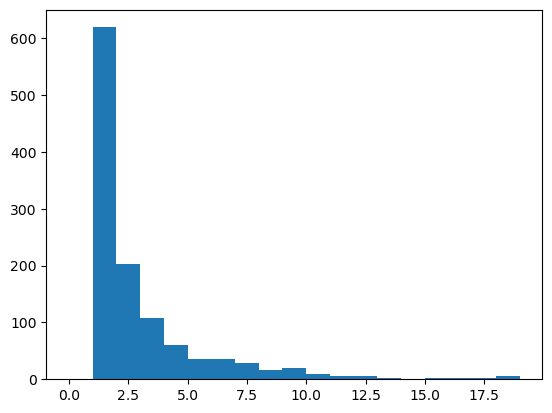

In [389]:
# aside: a given pair of cells do not seem to fire in the same ripple that often
weight_value = []
for key in weights_cont.keys():
    weight_value.append(weights_cont[key])
weight_value = np.array(weight_value)
plt.hist(weight_value[weight_value>0],bins = np.arange(20))

In [163]:
group = [53,24,41,16,28,83,60,58,16,48]
cell_clique = [np.array(cell_list)[i] for i in group]
for i in range(len(group)):
    print(group[i],' = ',cell_clique[i])

53  =  [17 14]
24  =  [13 17]
41  =  [16  8]
16  =  [13  7]
28  =  [14  9]
83  =  [30  4]
60  =  [20  8]
58  =  [20  5]
16  =  [13  7]
48  =  [17  7]


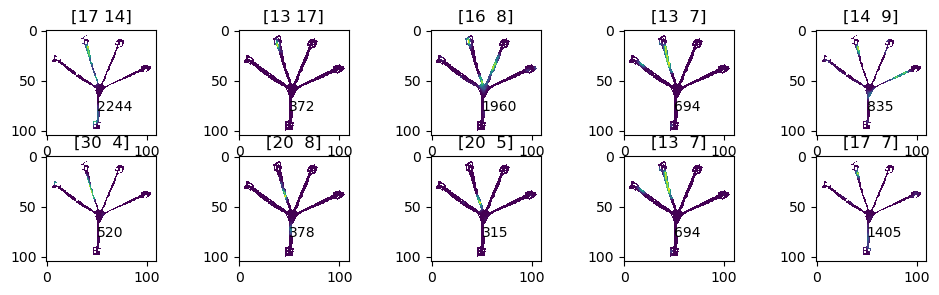

In [169]:
fig, axes = plt.subplots(2,int(np.ceil(len(cell_clique)/2)), figsize = (12,3), squeeze = True)

ind = 0
for p in cell_clique:
    (e,u) = p
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(p)
    axes[np.unravel_index(ind, axes.shape)].text(50,80,all_spike_counts[(e,u)])
    ind = ind + 1

### 3. cell correlation: continuous replay engages a different network than continuous replays

In [21]:
from spyglass.shijiegu.fragmented_graph import weight_from_xcorrelation,make_graph_from_weights,plot_graph

In [82]:
weights_cont = weight_from_xcorrelation(ripple_times, nwb_units_all, cell_list, cells_cont, cell_list,
                                 cont = True, DELTA_T = 0.01, span = 1)
weights_frag = weight_from_xcorrelation(ripple_times, nwb_units_all, cell_list, cells_frag, cell_list,
                                 cont = False, DELTA_T = 0.01, span = 1)

# the sum of weights_cont and weights_frag
weights = {}
for i in np.arange(len(cell_list)):
    for j in np.arange(len(cell_list)):
        weights[(i,j)] = 0
        
for key in weights_frag.keys():
    weights[key] += weights_frag[key]
    
for key in weights_cont.keys():
    weights[key] += weights_cont[key]

In [106]:
G_cont = make_graph_from_weights(weights_cont, weights_sub = None)
G_frag = make_graph_from_weights(weights_frag, weights_sub = None)
G = make_graph_from_weights(weights, threshold = 2, weights_sub = None)

In [113]:
cell0_ind_list = []
cell1_ind_list = []

for key in weights_frag.keys():
    (cell0_ind, cell1_ind) = key
    
    if weights_frag[key] >= 3:
        
        cell0_ind_list.append(cell0_ind)
        cell1_ind_list.append(cell1_ind)

cell0_list = np.array(cell_list)[np.unique(cell0_ind_list)]
cell1_list = np.array(cell_list)[np.unique(cell1_ind_list)]

### form group by correlation from continuous replays

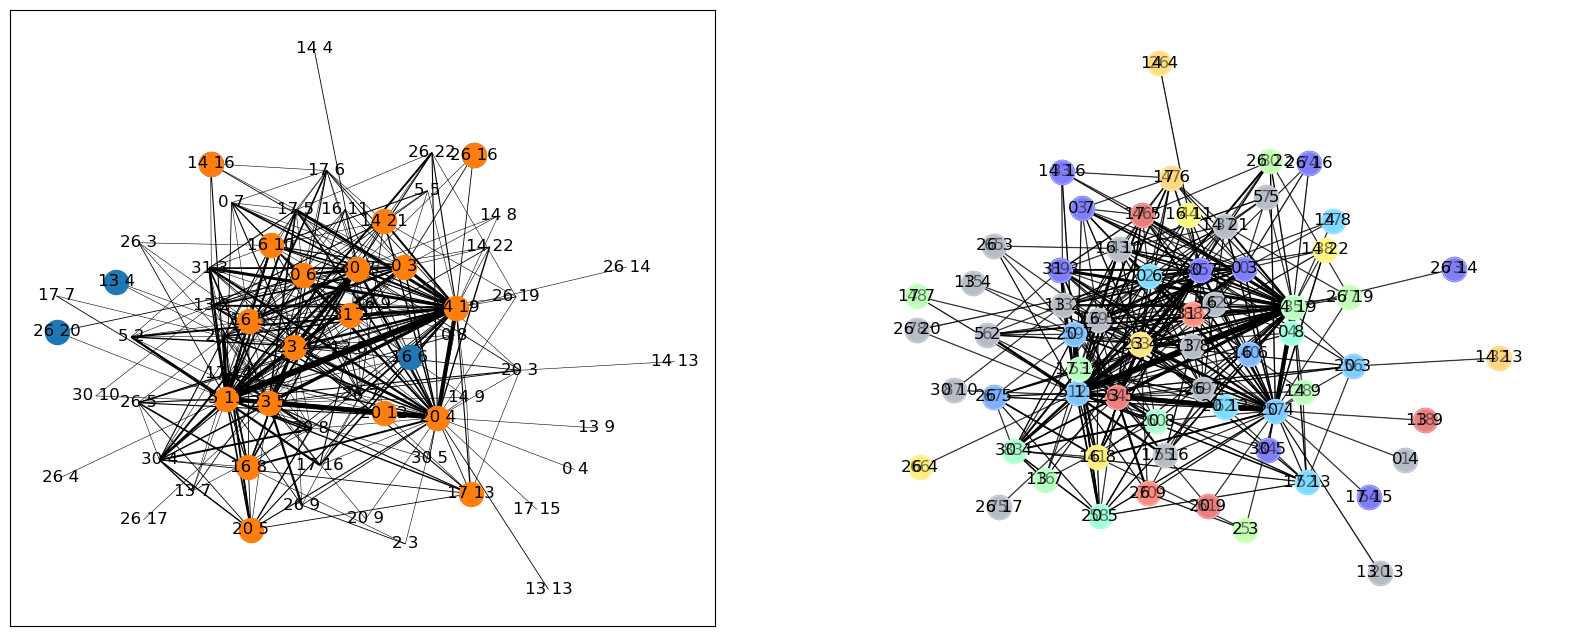

In [139]:
labels = {}
for n in G_cont.nodes:
    cell_name = np.array(cell_list)[n]
    label = str(cell_name[0])+' '+str(cell_name[1])
    labels[n] = label
    
pos, axes = plot_graph(G_cont, cell_list, labels, cell0_list, cell1_list,
                       color_ratio = color_ratio, color_fieldPeak = color_fieldPeak, version = 0)

### form group by correlation from continuous replays, add in edges from fragmented replays

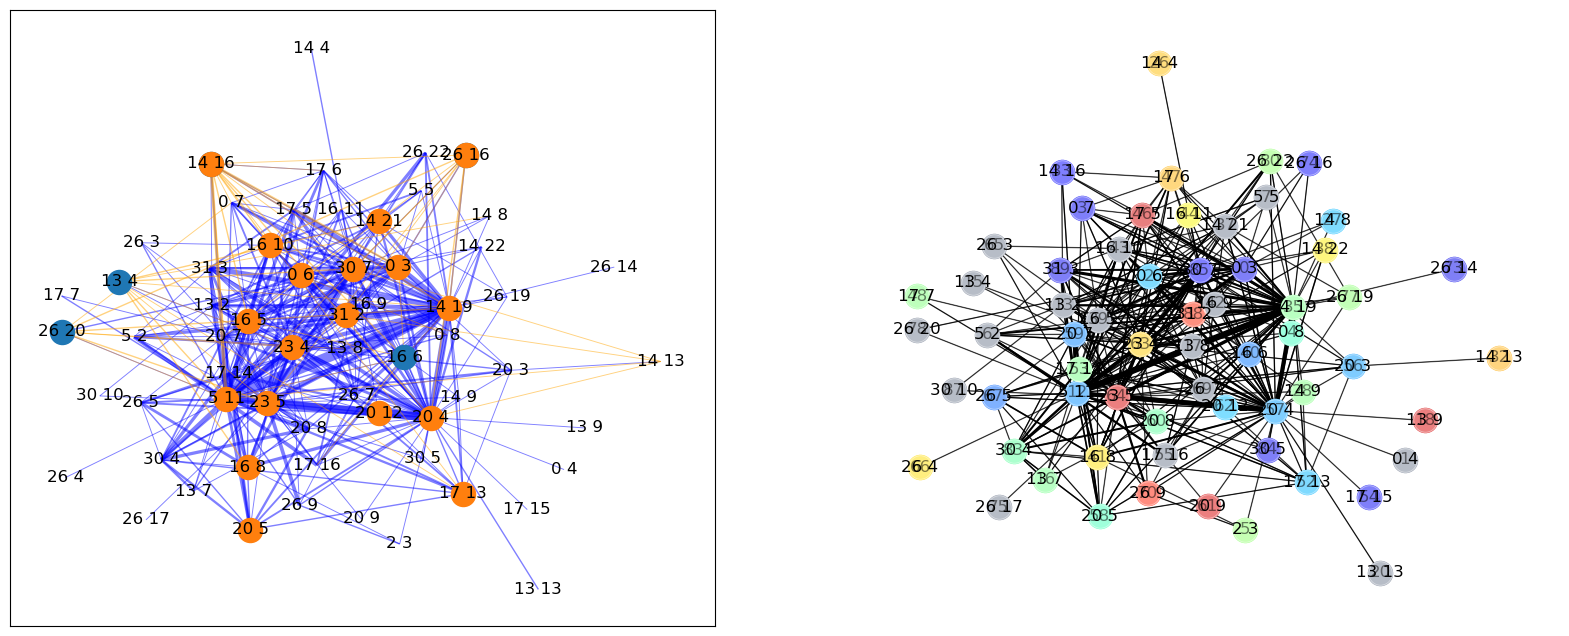

In [170]:
labels = {}
for n in G_cont.nodes:
    cell_name = np.array(cell_list)[n]
    label = str(cell_name[0])+' '+str(cell_name[1])
    labels[n] = label
    
pos, axes = plot_graph(G_cont, cell_list, labels, cell0_list, cell1_list,
                       color_ratio = color_ratio, color_fieldPeak = color_fieldPeak,
                       edge_color = 'blue',
                       version = 0)

for edge in G_frag.edges(data='weight'):
    try:
        nx.draw_networkx_edges(G_cont, pos, ax=axes[0], edgelist=[edge], edge_color = 'orange', alpha = 0.5, width=edge[2]/3)
    except:
        pass

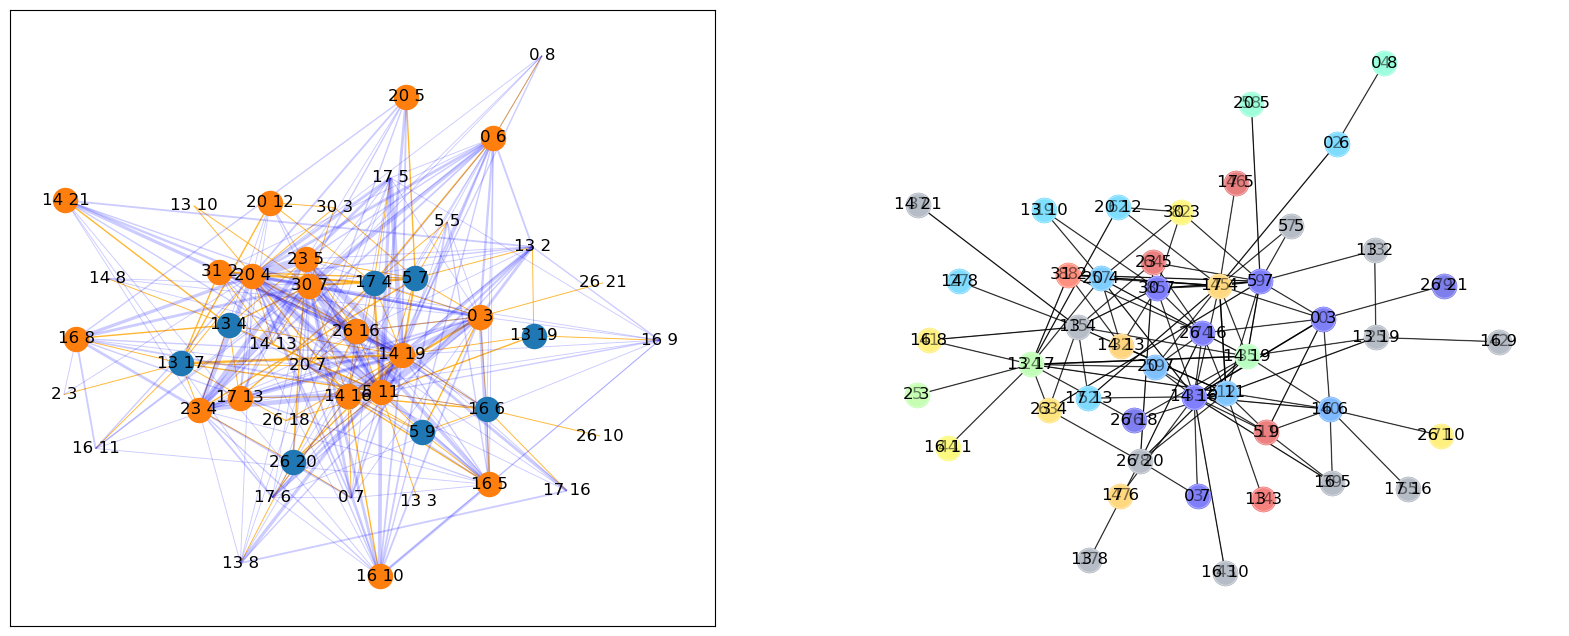

In [174]:
labels = {}
for n in G_frag.nodes:
    cell_name = np.array(cell_list)[n]
    label = str(cell_name[0])+' '+str(cell_name[1])
    labels[n] = label
    
pos, axes = plot_graph(G_frag, cell_list, labels, cell0_list, cell1_list,
                       edge_color = 'orange',alpha = 0.8,
                       color_ratio = color_ratio, color_fieldPeak = color_fieldPeak, version = 0)

for edge in G_cont.edges(data='weight'):
    try:
        nx.draw_networkx_edges(G_frag, pos, ax=axes[0], edgelist=[edge], edge_color = 'blue', alpha = 0.2, width=edge[2]/3)
    except:
        pass

In [149]:
nodes_weight_G_cont = np.array(sorted(G_cont.degree, key=lambda x: x[1], reverse=True))
nodes_G_cont = nodes_weight_G_cont[:,0]
weight_G_cont = nodes_weight_G_cont[:,1]

nodes_weight_G_frag = np.array(sorted(G_frag.degree, key=lambda x: x[1], reverse=True))
nodes_G_frag = nodes_weight_G_frag[:,0]
weight_G_frag = nodes_weight_G_frag[:,1]

In [157]:
common_cells = np.array(cell_list)[np.intersect1d(nodes_G_cont[:10],nodes_G_frag[:10])]
print(common_cells)

In [159]:
from spyglass.shijiegu.theta import plot_place_field_group

[14:18:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


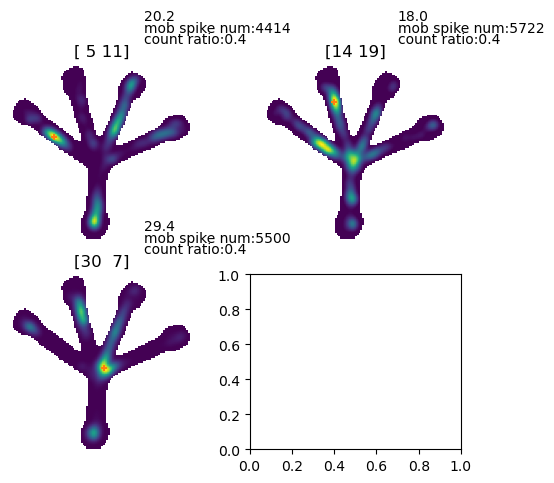

In [161]:
fig, axes = plot_place_field_group(common_cells,placefields,cell_list,
                           peak_frs = peak_frs,
                           mobility_spike_counts = mobility_spike_counts,
                           count_ratio = count_ratio, #the spike count ratio between continuous and frag replays
                           ref_cell_ind = None,
                           weightMatrix = None)

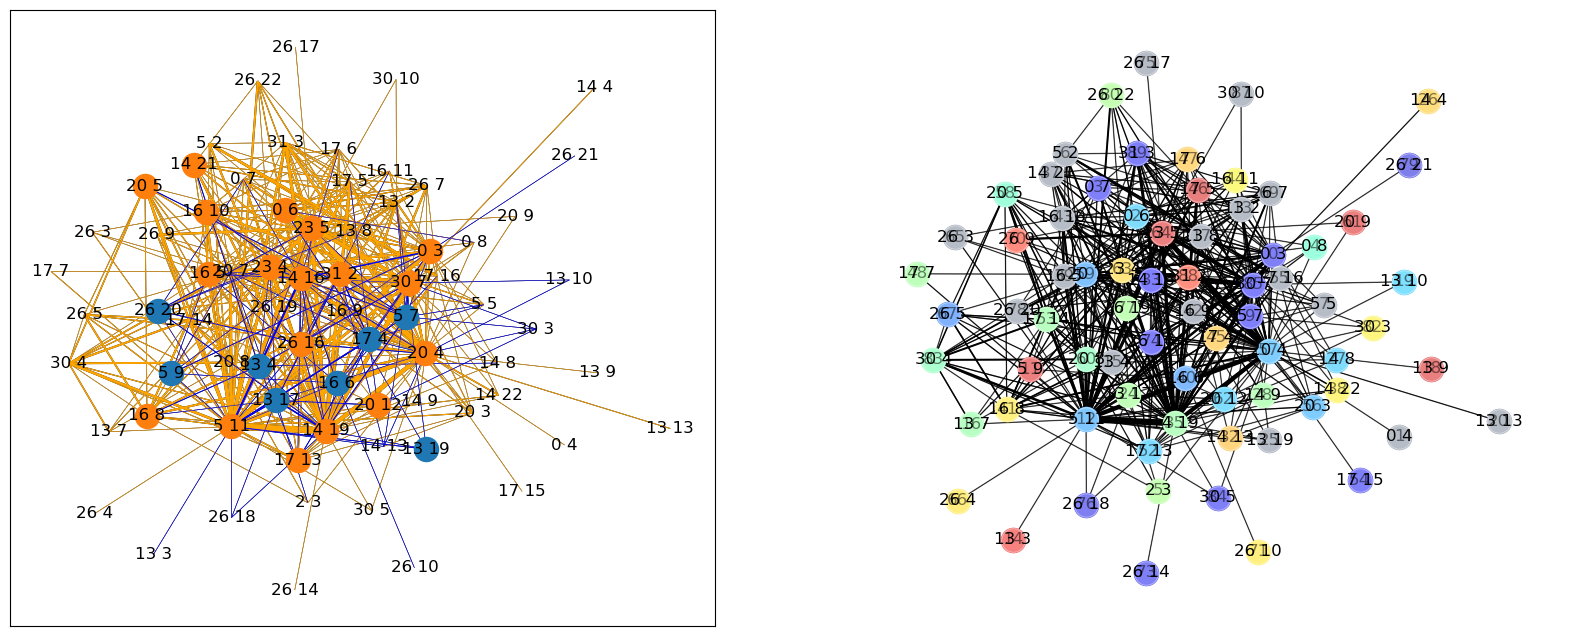

In [132]:
labels = {}
for n in G.nodes:
    cell_name = np.array(cell_list)[n]
    label = str(cell_name[0])+' '+str(cell_name[1])
    labels[n] = label
    
pos, axes = plot_graph(G, cell_list, labels, cell0_list, cell1_list,
                       color_ratio = color_ratio, color_fieldPeak = color_fieldPeak, version = 0)
for edge in G_cont.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=[edge], edge_color = 'orange',width=edge[2]/5)

for edge in G_frag.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=[edge], edge_color = 'blue',width=edge[2]/5)

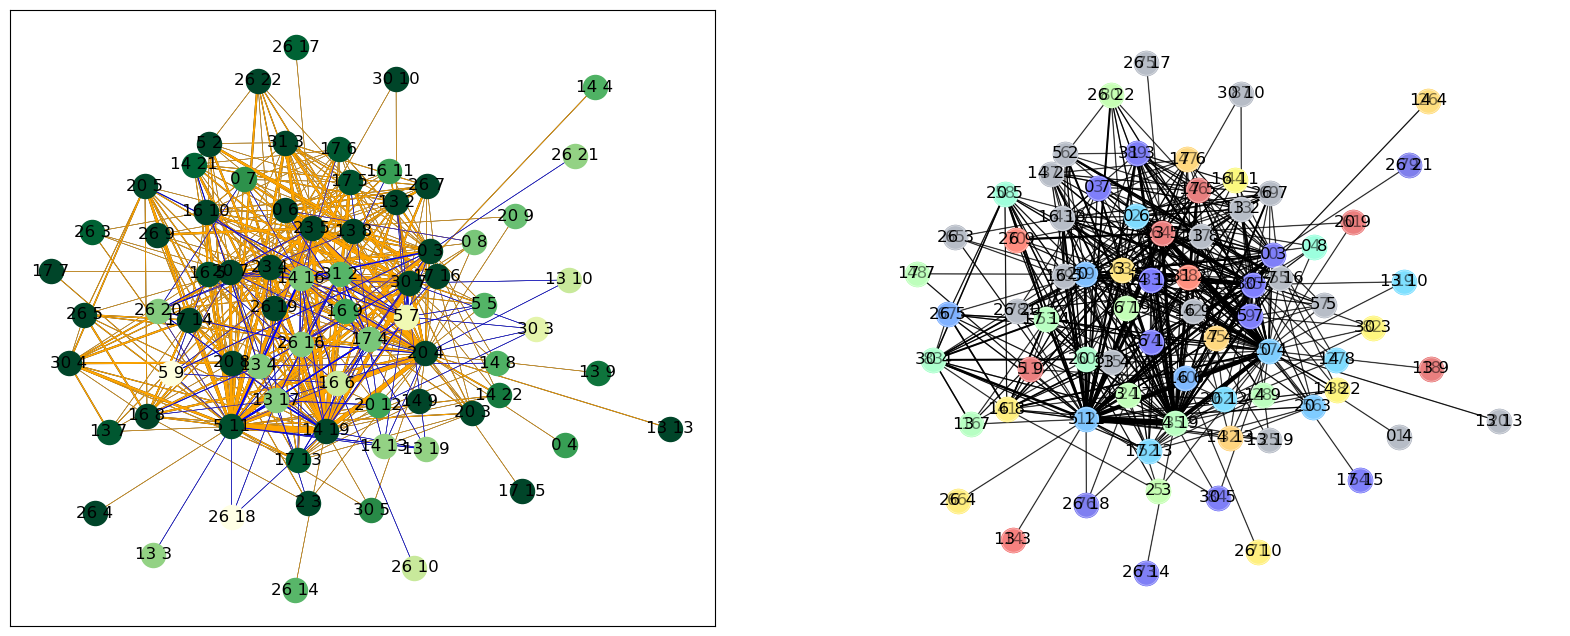

In [135]:
pos, axes = plot_graph(G, cell_list, labels, cell0_list, cell1_list,
                       color_ratio = color_ratio, color_fieldPeak = color_fieldPeak, version = 1)
for edge in G_cont.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=[edge], edge_color = 'orange',width=edge[2]/5)

for edge in G_frag.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=[edge], edge_color = 'blue',width=edge[2]/5)

(array([  0., 716., 265., 133.,  94.,  60.,  69.,  37.,  43.,  38.,  16.,
         13.,   5.,   9.,   3.,   4.,   2.,   2.,   7.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 19 artists>)

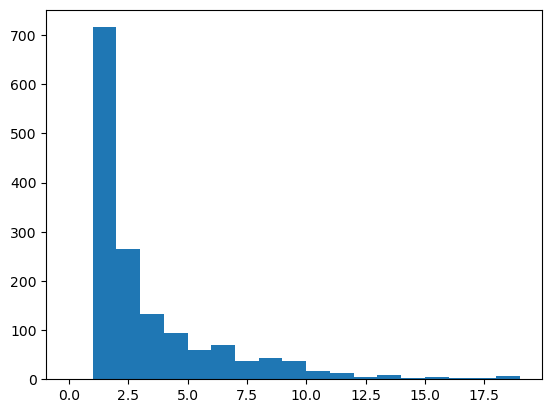

In [416]:
# aside: a given pair of cells do not seem to fire in the same ripple that often
weight_value = []
for key in weights_cont_cont.keys():
    weight_value.append(weights_cont_cont[key])
weight_value = np.array(weight_value)
plt.hist(weight_value[weight_value>0],bins = np.arange(20))

In [364]:
#G_prime, cell0_list, cell1_list = make_graph_from_xcorrelation(ripple_times, nwb_units_all, cells_cont, cell_list, DELTA_T = 0.01)

In [412]:
np.argwhere(np.sum(np.array(cell_list) == (30,4),1) == 2)

array([[83]])

In [413]:
for i in np.arange(len(cell_list)):
    if weights_cont_cont[(83,i)] > 0:
        print(cell_list[i],weights_cont_cont[(83,i)])

(0, 3) 1
(0, 4) 1
(0, 6) 1
(0, 8) 1
(2, 3) 1
(5, 2) 1
(5, 11) 10
(13, 4) 1
(13, 7) 6
(13, 13) 2
(14, 19) 6
(14, 21) 1
(16, 5) 2
(16, 8) 5
(16, 10) 1
(16, 11) 1
(17, 6) 1
(17, 10) 1
(17, 13) 4
(17, 14) 9
(17, 15) 1
(20, 3) 1
(20, 4) 8
(20, 5) 9
(20, 7) 4
(20, 8) 8
(23, 4) 7
(23, 5) 4
(26, 5) 5
(26, 7) 1
(30, 5) 2
(30, 7) 1
(30, 9) 1
(31, 2) 1
(31, 3) 1


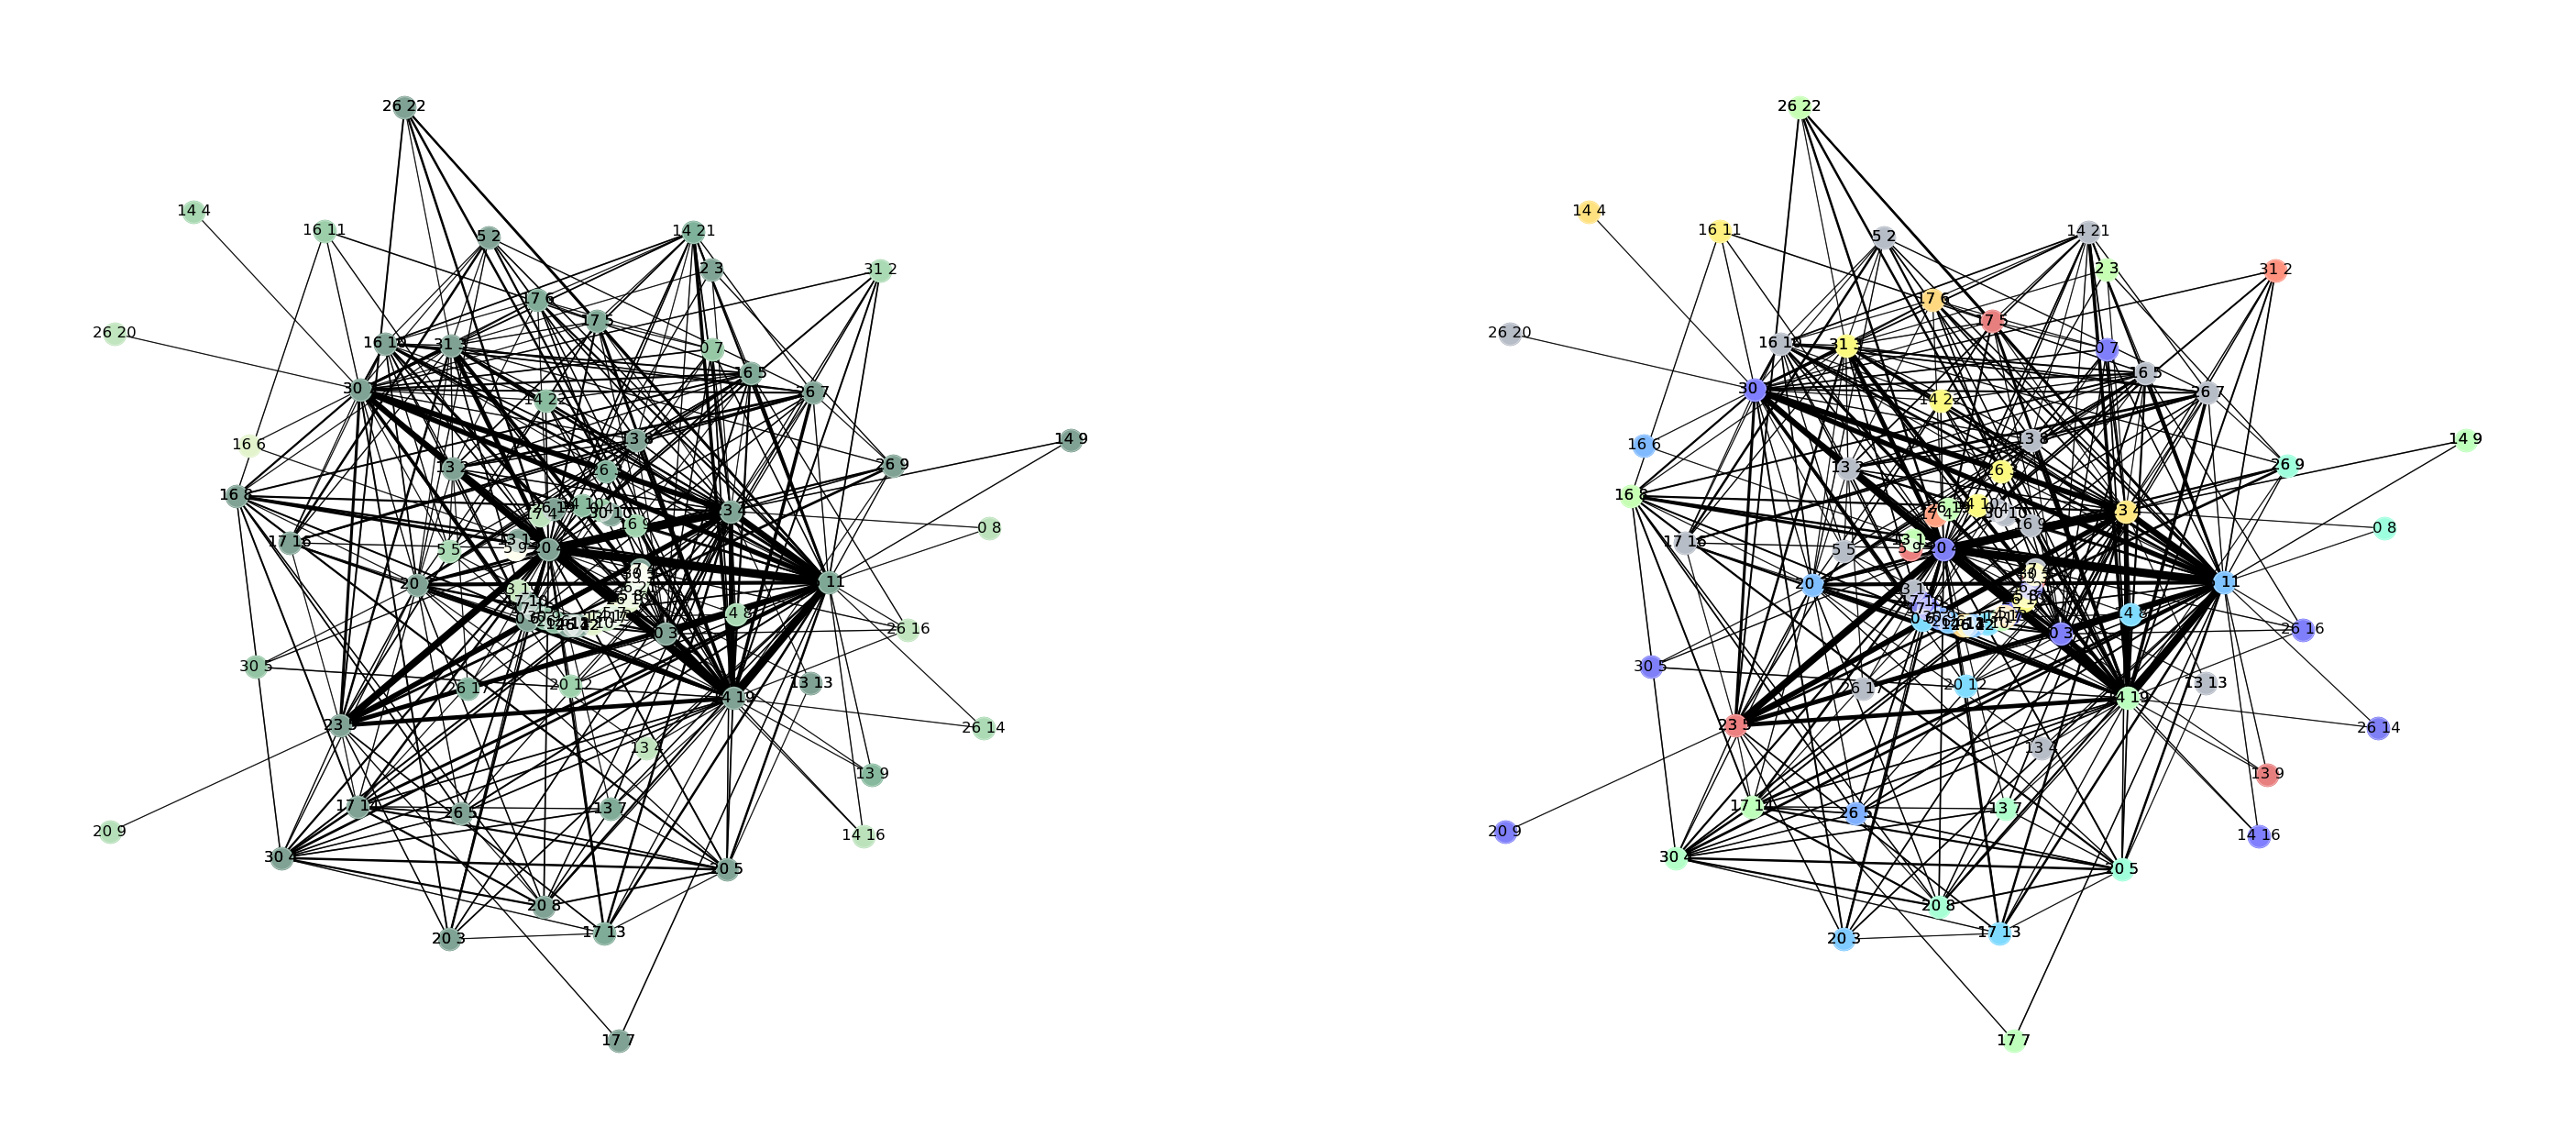

In [433]:
plot_graph(G_cont_cont,cell0_list,cell1_list)

In [383]:
G_frag_cont, cell0_list, cell1_list = make_graph_from_xcorrelation(ripple_times, nwb_units_all, cells_frag, cell_list, 
                                                                   cont = True, DELTA_T = 0.01)

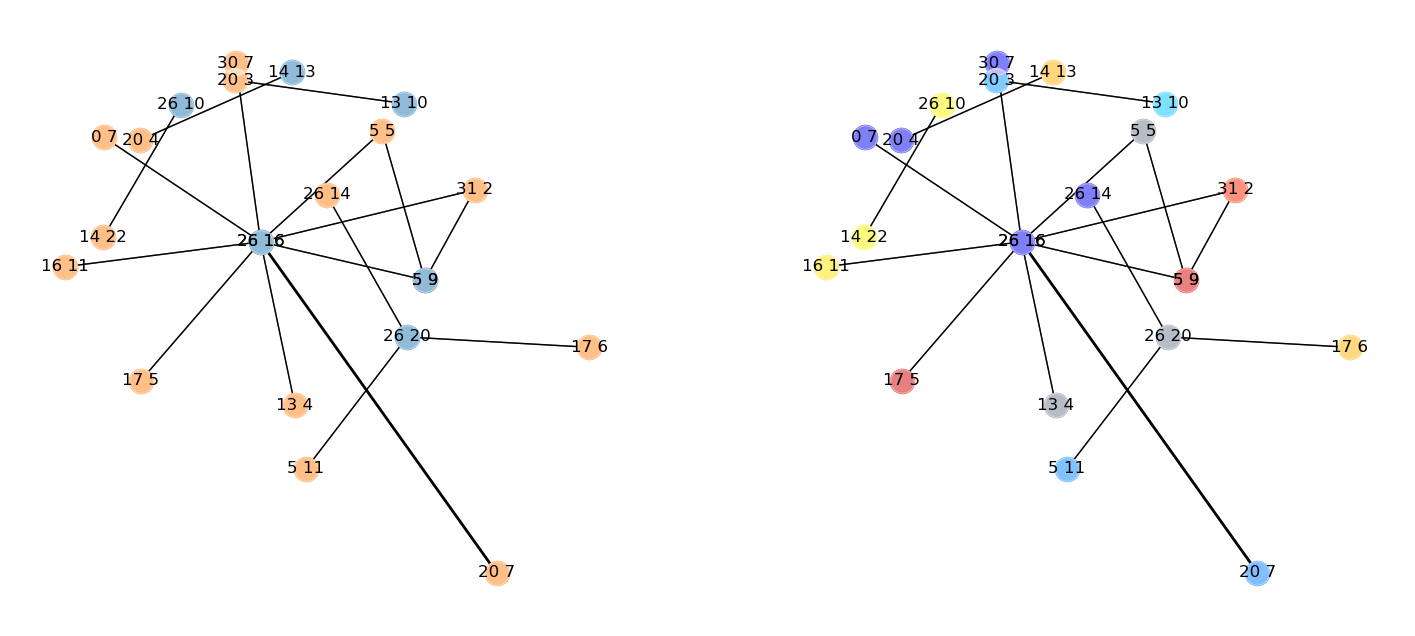

In [385]:
plot_graph(G_frag_cont, cell0_list, cell1_list, version = 0)

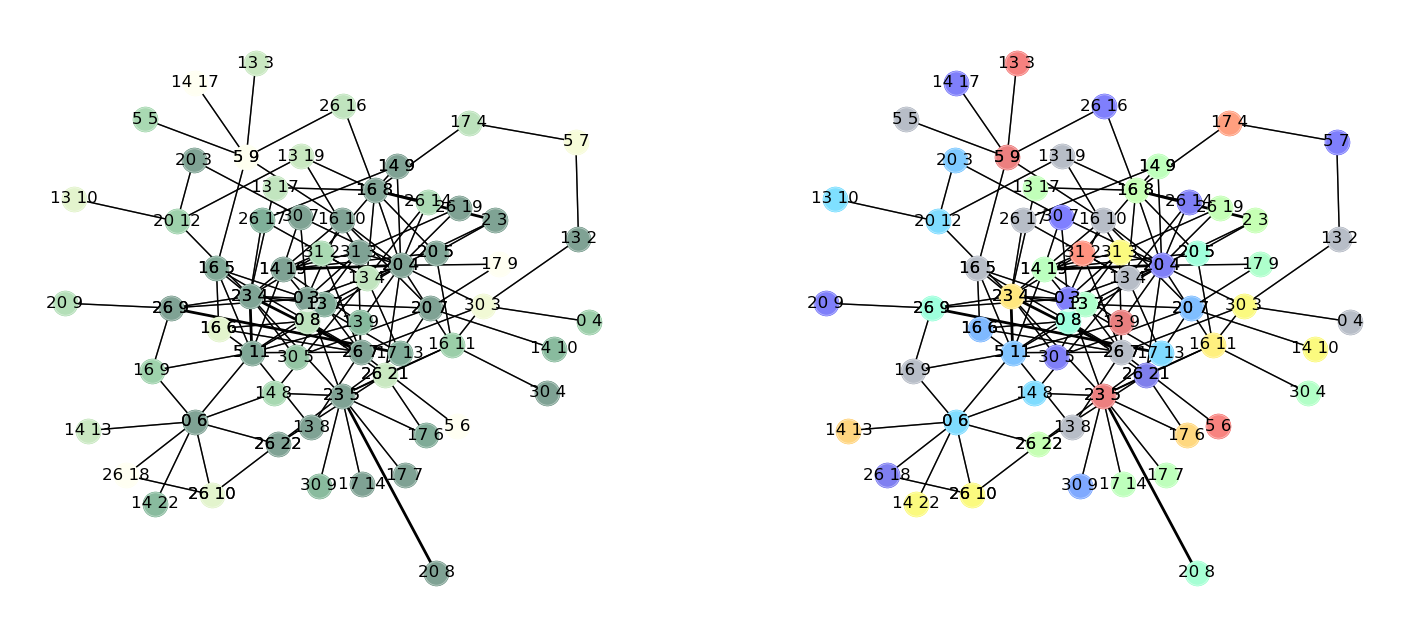

In [367]:
#pos = nx.spring_layout(G)  # positions for all nodes
fig, axes = plt.subplots(1,2, figsize = (18,8))

pos = nx.kamada_kawai_layout(G,scale = 2)

#pos = nx.bfs_layout(G)
"""
nx.draw_networkx_nodes(G, pos, ax = axes[0], nodelist=cell1_list.keys(), node_color="tab:orange") #the order of plotting matters here
nx.draw_networkx_nodes(G, pos, ax = axes[0], nodelist=cell0_list.keys(), node_color="tab:blue")
"""

# ratio color
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    try:
        nx.draw_networkx_nodes(G, pos, ax=axes[0], 
                               nodelist=[cell_ind], node_color=color_ratio[cell]) #the order of plotting matters here
    except:
        pass
       
nx.draw(G, pos, ax = axes[0], with_labels=False, alpha = 0.5, node_color="white")

nx.draw_networkx_labels(G,pos,cell0_list, ax = axes[0]);
nx.draw_networkx_labels(G,pos,cell1_list, ax = axes[0]);

for edge in G.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=[edge], width=edge[2])

# color_fieldPeak
for cell_ind in range(len(cell_list)):
    cell = cell_list[cell_ind]
    try:
        nx.draw_networkx_nodes(G, pos, ax=axes[1], 
                               nodelist=[cell_ind], node_color=color_fieldPeak[cell]) #the order of plotting matters here
    except:
        pass
nx.draw(G, pos, ax = axes[1], with_labels=False, alpha = 0.5, node_color="white")
nx.draw_networkx_labels(G,pos,cell0_list, ax = axes[1]);
nx.draw_networkx_labels(G,pos,cell1_list, ax = axes[1]);

#nx.draw(G, pos, with_labels=True, font_weight='bold')
for edge in G.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, ax=axes[1], edgelist=[edge], width=edge[2])

[array([26, 18]), array([13, 14]), array([14, 17]), array([5, 7]), array([5, 6]), array([20, 12]), array([26, 14]), array([26, 10]), array([17,  9])]


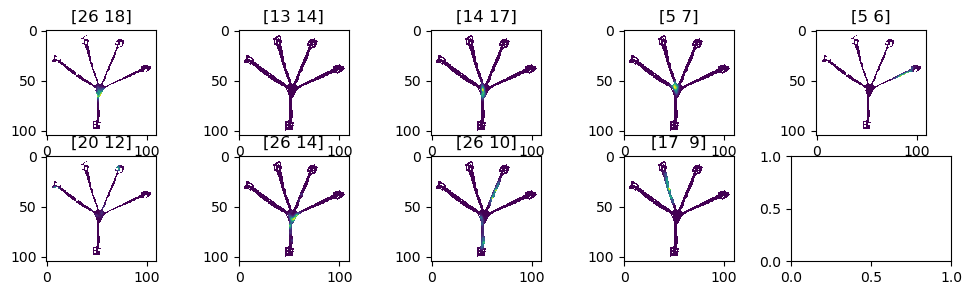

In [105]:
cell_clique = [np.array(cell_list)[i] for i in [76,21,34,9,8,62,73,71,49]]
print(cell_clique)
fig, axes = plt.subplots(2,int(np.ceil(len(cell_clique)/2)), figsize = (12,3), squeeze = True)

ind = 0
for p in cell_clique:
    (e,u) = p
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(p)
    ind = ind + 1

[array([17,  9]), array([14, 10]), array([17, 16]), array([20,  8]), array([31,  2])]


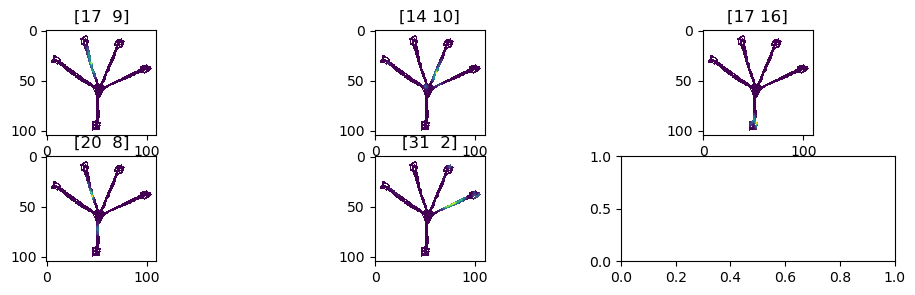

In [115]:
cell_clique = [np.array(cell_list)[i] for i in [49,29,55,60,88]]
print(cell_clique)
fig, axes = plt.subplots(2,int(np.ceil(len(cell_clique)/2)), figsize = (12,3), squeeze = True)

ind = 0
for p in cell_clique:
    (e,u) = p
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)])
    axes[np.unravel_index(ind, axes.shape)].set_title(p)
    ind = ind + 1